In [198]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import json
from copy import deepcopy
from latex_table import Table

In [211]:

class ChartGroup:

    def __init__(self, nrows, ncols, width_ratios=None, height_ratios=None) -> None:
        self.fig = plt.figure(constrained_layout=True)

        if width_ratios is None:
            width_ratios = [1] * ncols
        if height_ratios is None:
            height_ratios = [1] * nrows

        subfigs = self.fig.subfigures(nrows, ncols, width_ratios=width_ratios, height_ratios=height_ratios)

        total_height = sum(height_ratios) * Chart.figheight
        total_width = sum(width_ratios) * Chart.figwidth

        self.fig.set_figwidth(total_width)
        self.fig.set_figheight(total_height)

        self.charts = []
        x = 0
        for i  in range(nrows):
            charts_row = []
            for j in range(ncols):
                if nrows == 1 or ncols == 1:
                    charts_row.append(Chart(subfigs[x]))
                else:
                    charts_row.append(Chart(subfigs[i, j]))
                x += 1
            self.charts.append(charts_row)
    
    def get_chart(self, row, col):
        return self.charts[row - 1][col - 1]

class Chart:
    
    color_scheme1 = ['#fb8072', '#80b1d3', '#b3de69', '#fdb462', '#8dd3c7', '#ffffb3', '#bebada', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', 'ffed6f']
    color_scheme2 = ['#D7191C', '#2C7BB6', '#00FF00', 'orange', '#a6a832', '#3632a8', '#D7191C', '#2C7BB6']

    legend_fontsize = 14
    legend_loc = 'upper right'
    innertext_fontsize = 12
    xticks_fontszie = 12
    yticks_fontszie = 12
    figwidth = 4
    figheight = 4

    def __init__(self, fig=None) -> None:
        if fig is None:
            fig = plt.figure(figsize=(self.figwidth, self.figheight))
        self.fig = fig
        self.ax = fig.add_subplot()
        self.ax.tick_params('x', labelsize=self.xticks_fontszie)
        self.ax.tick_params('y', labelsize=self.yticks_fontszie)
        self.colors = self.color_scheme1
    
    def config(self, xticks_fontsize, yticks_fontsize):
        self.ax.tick_params('x', labelsize=xticks_fontsize)
        self.ax.tick_params('y', labelsize=yticks_fontsize)
    
    def set_legend_loc(self, loc):
        self.legend_loc = loc
    
    def set_colors(self, colors):
        self.colors = colors
    
    def set_figsize(self, width, height):
        self.fig.set_figwidth(width)
        self.fig.set_figheight(height)
    
    def table(self, data, headers, caption='', float_format='%.2f', 
              int_format='%.2f', template='table_core.txt', merge_cells=True, fontsize=5):
        latex_table = Table(data, headers, caption, float_format, int_format, template, merge_cells, fontsize)
        latex_plt = latex_table.to_latex_plt()

        plt.rc('text.latex', preamble=r'\usepackage{booktabs} \usepackage{multirow} \usepackage{caption} \usepackage{makecell}')
        self.ax.text(0.05, 0.05, latex_plt, usetex=True)
        
    def line(self, x, y, color):
        if isinstance(color, int):
            color = self.colors[color]
        self.ax.plot(x, y, color=color)
    
    def slice(self, volume, orientation, slice_index='mid', voxsz=(1, 1, 1), cmap='gray', origin='lower'):
        if orientation == 'x':
            if slice_index == 'mid':
                slice_index = volume.shape[0] // 2
            slice = volume[slice_index, :, :]
            aspect = voxsz[2] / voxsz[1]
        
        if orientation == 'y':
            if slice_index == 'mid':
                slice_index = volume.shape[1] // 2
            slice = volume[:, slice_index, :]
            aspect = voxsz[2] / voxsz[0]
        
        if orientation == 'z':
            if slice_index == 'mid':
                slice_index = volume.shape[2] // 2
            slice = volume[:, :, slice_index]
            aspect = voxsz[1] / voxsz[0]
        
        self.ax.imshow(slice.T, cmap='gray', aspect=aspect, origin=origin)
    
    def boxplot(self, data, bar_labels=None, series_labels=None, showfliers=False, 
                show_stats='median', 
                significance_pairs=None,
                barwidth=0.4, space_between_bars=0.2, space_between_groups=1,
                auto_figsize=True, style='2'):

        def set_box_color_style1(bp, color):
            plt.setp(bp['boxes'], color=color)
            plt.setp(bp['whiskers'], color=color)
            plt.setp(bp['caps'], color=color)
            plt.setp(bp['medians'], color=color)
        
        def set_box_color_style2(bp, color):
            for patch in bp['boxes']:
                patch.set_facecolor(color)
                plt.setp(bp['medians'], color='black')
            

        num_series = len(data)
        num_bars = len(data[0])

        if auto_figsize and isinstance(self.fig, plt.Figure):
            height = self.fig.get_figheight()
            width = 0.6 * num_series * num_bars
            self.set_figsize(width=width, height=height)

        first_series_bar_positions = np.array(range(num_bars)) * num_series
        first_series_bar_positions = np.array([i * ((barwidth + space_between_bars) * (num_series - 1) + space_between_groups) for i in range(num_bars)])

        bar_topcoords = []
        legend_marker = []

        for i, item in enumerate(data):
            bar_positions = first_series_bar_positions + (barwidth + space_between_bars) * i
            boxes = self.ax.boxplot(
                item,
                positions=bar_positions,
                patch_artist=style == '2',
                sym='.',
                widths=barwidth,
                showfliers=showfliers
            )

            style_funcs = {'1': set_box_color_style1, '2': set_box_color_style2}
            style_funcs[style](boxes, self.colors[i])
            legend_marker.append(boxes['boxes'][0])

            cur_bar_topcoords = []
            for j in range(num_bars):
                x, y = boxes['whiskers'][j * 2 + 1].get_xydata().max(axis=0)
                if showfliers:
                    fliers = boxes['fliers'][j].get_xydata()
                    if fliers.shape[0] > 0:
                        x, y = fliers.max(axis=0)
                cur_bar_topcoords.append([x, y])
            
            bar_topcoords.append(cur_bar_topcoords)

        if show_stats is not None:
            for i in range(len(data)):
                for j in range(num_bars):
                    x, y = bar_topcoords[i][j]
                    cur_data = data[i][j]
                    if show_stats == 'median':
                        stats = np.median(cur_data)
                    else:
                        stats = 0
                    self.ax.text(x - 0.2, y + 0.5, '%.2f' % stats, color='black', fontsize=self.innertext_fontsize)

        if significance_pairs is not None:

            verticle_gap_ratio = 0.03
            verticle_line_ratio = 0.1

            left_bar_topcoords = deepcopy(bar_topcoords)
            right_bar_topcoords = deepcopy(bar_topcoords)
            
            ymin = self.ax.dataLim.get_points()[0, 1]
            ymax = self.ax.dataLim.get_points()[1, 1]

            new_ymax = ymax

            for pair in significance_pairs:

                x1 = bar_topcoords[pair[0][0]][pair[0][1]][0]
                x2 = bar_topcoords[pair[1][0]][pair[1][1]][0]

                delta_x = 0.1 * barwidth
                if x1 < x2:
                    bar_topcoords1 = right_bar_topcoords
                    bar_topcoords2 = left_bar_topcoords
                    x1 += delta_x
                    x2 -= delta_x
                else:
                    bar_topcoords1 = left_bar_topcoords
                    bar_topcoords2 = right_bar_topcoords
                    x1 -= delta_x
                    x2 += delta_x
                
                y1 = bar_topcoords1[pair[0][0]][pair[0][1]][1]
                y2 = bar_topcoords2[pair[1][0]][pair[1][1]][1]

                y = max(y1, y2) + verticle_line_ratio * ymax
                y1 += verticle_gap_ratio * ymax
                y2 += verticle_gap_ratio * ymax
                
                self.line([x1, x1], [y1, y], color='black')
                self.line([x2, x2], [y2, y], color='black')
                self.line([x1, x2], [y, y], color='black')

                bar_topcoords1[pair[0][0]][pair[0][1]][1] = y
                bar_topcoords2[pair[1][0]][pair[1][1]][1] = y
                new_ymax = max(y + verticle_gap_ratio * ymax, new_ymax)
            
            self.yticks(minv=ymin, maxv=new_ymax)

                
        if show_stats is not None:
            stats = []
        
        if series_labels is not None:
            self.ax.legend(legend_marker, series_labels, loc=self.legend_loc, fontsize=self.legend_fontsize)
        
        if num_series % 2 == 0:
            xtics = first_series_bar_positions + (barwidth + space_between_bars) * (num_series / 2) - (barwidth + space_between_bars) / 2
        else:
            xtics = first_series_bar_positions + (barwidth + space_between_bars) * (num_series // 2)

        if bar_labels is None:
            bar_labels = ['%.2f' % p for p in xtics]
        self.xticks(ticks=xtics, labels=bar_labels)
    
    def xlabel(self, label):
        self.ax.set_xlabel(label)
    
    def ylabel(self, label):
        self.ax.set_ylabel(label)

    def xticks(self, minv=None, maxv=None, num=None, ticks=None, labels=None):
        if ticks is None and num is None:
            self.ax.set_xlim(bottom=minv, top=maxv)
            return
        if ticks is None:
            ticks = np.linspace(start=minv, stop=maxv, num=num)
        self.ax.set_xticks(ticks, labels=labels)
    
    def yticks(self, minv=None, maxv=None, num=None, ticks=None, labels=None):
        if ticks is None and num is None:
            self.ax.set_ylim(bottom=minv, top=maxv)
            return
        if ticks is None:
            ticks = np.linspace(start=minv, stop=maxv, num=num)
        self.ax.set_yticks(ticks, labels=labels)
        
        

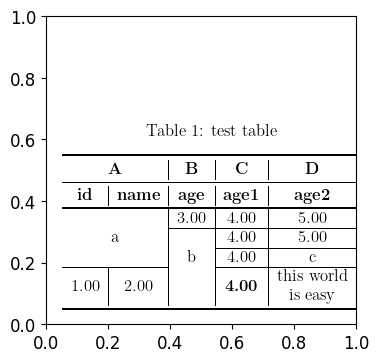

In [206]:
data = [
        ['a', 'a', 3, 4, 5],
        ['a', 'a', 'b', 4, 5],
        ['a', 'a', 'b', 4, 'c'],
        [1, 2, 'b', '<b>4', r'this world \\ is easy']

    ]
chart = Chart()
chart.table(
    data=data,
    caption='test table',
    headers=[['A', 'A', 'B', 'C', 'D'], ['id', 'name', 'age', 'age1', 'age2']],
    merge_cells=True
)

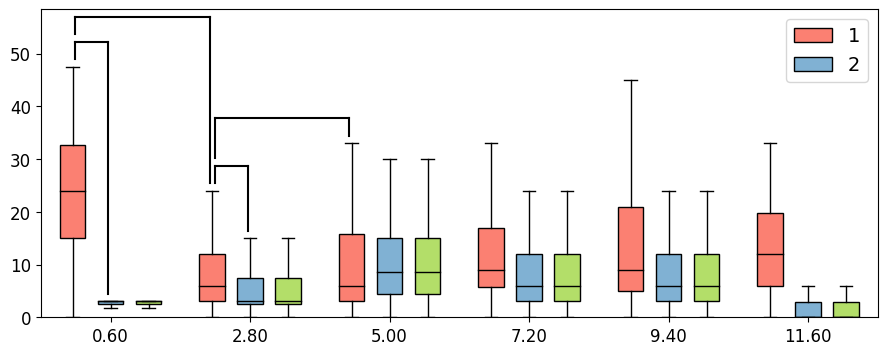

In [213]:

significance_pairs = [
    [(0, 0), (1, 0)],
    [(0, 0), (0, 1)],
    [(0, 1), (1, 1)],
    [(0, 1), (0, 2)]
]

chart = Chart()
data = [means[0], means[1], means[1]][:3]
chart.boxplot(data, series_labels=['1', '2'], space_between_groups=1, showfliers=False, style='2', significance_pairs=significance_pairs, show_stats=None)

In [141]:
img = nib.load('data/testimg1.nii.gz')
img_data = img.get_fdata().astype(np.float32)
img.header.get_zooms()

(3.7734375, 3.7734375, 0.4000244)

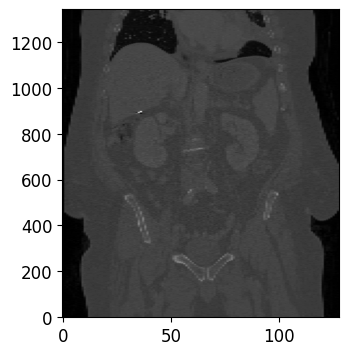

In [145]:
chart = Chart()
chart.slice(img_data, orientation='y', voxsz=img.header.get_zooms())
# chart.line([60, 60], [100, 40], color='red')

In [26]:
chart.ax.dataLim

Bbox([[1.0, 3.0], [2.0, 4.0]])

In [4]:
gt_pca_scores = json.load(open('E:/dingjie/mipresearch/body_part_regression/analyze/score_assignment_all_slices_commonpca_train.json'))
sbpreg_scores3 = json.load(open('E:/dingjie/mipresearch/body_part_regression/bpr_new/exp/Exp_semi-order_c-batch32vs4_3/evaluation/score_pred.json'))
ks_labels_all = json.load(open('../all_key_slice_labels.json'))
dataset = json.load(open('E:/dingjie/mipresearch/body_part_regression/bpr_new/dataset.json'))

scores_to_compare = [
    sbpreg_scores3,
    gt_pca_scores
    # sbpreg_scores4_reg
]

ks_labels = {}
for k, v in ks_labels_all.items():
    if k in dataset['test']:
        ks_labels[k] = v

gt_ks_scores = {
    1: -1,
    2: -0.64,
    3: -0.42,
    4: -0.04,
    5: 0.20,
    6: 0.21,
    7: 0.53,
    8: 1
}

errors = [
    {2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []} for i in range(len(scores_to_compare))
]

busn_errors = {2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
bpreg_errors = {2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
sbpreg_errors = {2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}

for k, v in ks_labels.items():
    if int(v['status']) != 1: continue
    #if not (k in busn_scores and k in bpreg_scores): continue

    img = nib.load(f'E:/dingjie/mipresearch/body_part_regression/thomas/dataset/unique_subject/images/{k}.nii.gz')
    z_spacing = img.affine[2, 2]

    for k1, v1 in v['key_slices'].items():
        if int(k1) == 1: continue
        for i in range(len(scores_to_compare)):
            cur_errors = []
            cur_scores = scores_to_compare[i]

            atlas_score = gt_ks_scores[int(k1)]
            pat_scores = cur_scores[k]['score']

            index_pred = cur_scores[k]['slice_index'][np.abs(np.array(cur_scores[k]['score']) - atlas_score).argmin()]
            index_gt = int(v1['slice_index'])

            cur_error = abs(index_pred - index_gt) * z_spacing
            cur_errors.append(cur_error)
                
            errors[i][int(k1)].append(np.mean(cur_errors))

# excels = [
# 'OSS_instance_category_error.xlsx',
# 'CC_instacne_category_error.xlsx',
# ]

labels = [str(i) for i in range(len(scores_to_compare))]
errors = dict(zip(labels, errors))

keys = ['Neck end', 'Aorta arc', 'Liver start', 'Pancrease mid', 'Kidney end', 'Femur end']
#keys = ['CC']
title = ''
ylims = [0, 100]

means = []

median_values = []

# for k in [2, 3, 4, 5, 6, 7, 8]:
#     k = str(k)
#     means.append([errors['busn'][k], errors['bpreg'][k]])

for k in labels:
    means.append([errors[k][k1] for k1 in [2, 3, 4, 6, 7, 8]])


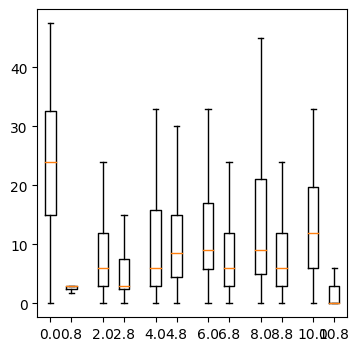

In [80]:
chart = Chart()
chart.boxplot(means)